In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPRegressor

In [34]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# PCA features - number of qubits
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [35]:
def load_patient_data(patiend_id):
    # Loads signal and extracts heartbeats based on annotations
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # Loads patient ECG signal, extracting the MLII column
    df_ekg = pd.read_csv(ekg_file)
    # Strips spaces from column names (common CSV issue)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # If names are missing, use index 1 (0 is usually time/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Clean names
            
        # Locate relevant columns (sample = position, symbol = type)
        # Names may vary ('sample', 'Sample', 'time', etc.)
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Skip heartbeats at the beginning or end of the recording
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Extract segment
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Ensure exact length
        if len(window) != WINDOW_SIZE:
            continue

        # Classification
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Normal): 1200
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...
Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


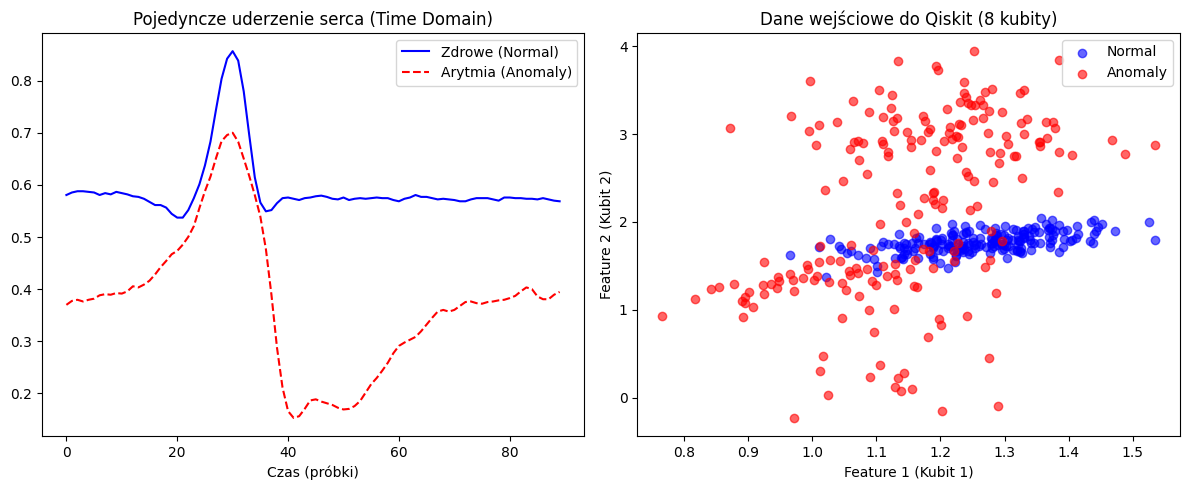

In [36]:
# --- DATA COLLECTION ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Convert to numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nSTATUS DANYCH SUROWYCH:")
print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
print(f"Liczba próbek Test (Normal): {X_test_normal.shape[0]}")
print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
    raise ValueError

# --- # PROCESSING (PCA) ---
print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")

# 1. Fit PCA only on healthy training data
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transform all datasets
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# 3. Handle case with no anomalies to prevent crashes
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

# --- QUANTUM SCALING ---
# Qiskit prefers data in (0, pi) or (-1, 1) range.
# We use (0, pi) for rotation gates.
print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Fit scaler on training data

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- SAVING ---
print("\n>>> KROK 5: Zapisywanie plików .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

# --- VISUALIZATION ---
print("\n>>> Generowanie wykresu kontrolnego...")
plt.figure(figsize=(12, 5))

# Plot 1: Raw heartbeat visualization
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
plt.title("Pojedyncze uderzenie serca (Time Domain)")
plt.xlabel("Czas (próbki)")
plt.legend()

# Plot 2: Post-PCA visualization
plt.subplot(1, 2, 2)
# Plot only 100 points for readability
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
plt.xlabel("Feature 1 (Kubit 1)")
plt.ylabel("Feature 2 (Kubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

>>> START: KLASYCZNY AUTOENKODER (Input: 8 -> Hidden: 4 -> Output: 8)
    Trening na: 600 próbkach
    Dane treningowe: (600, 8)
>>> Trenowanie sieci neuronowej...
    Trening zakończony.
    Końcowy Loss: 0.043879


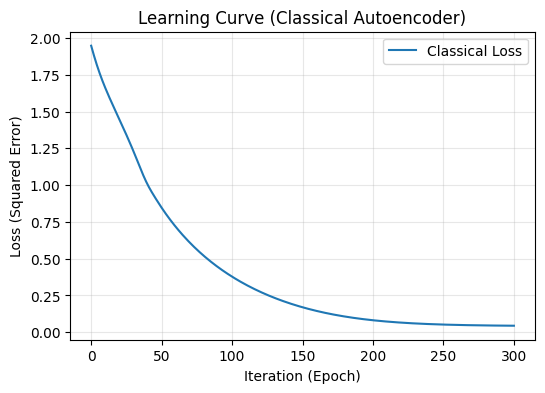

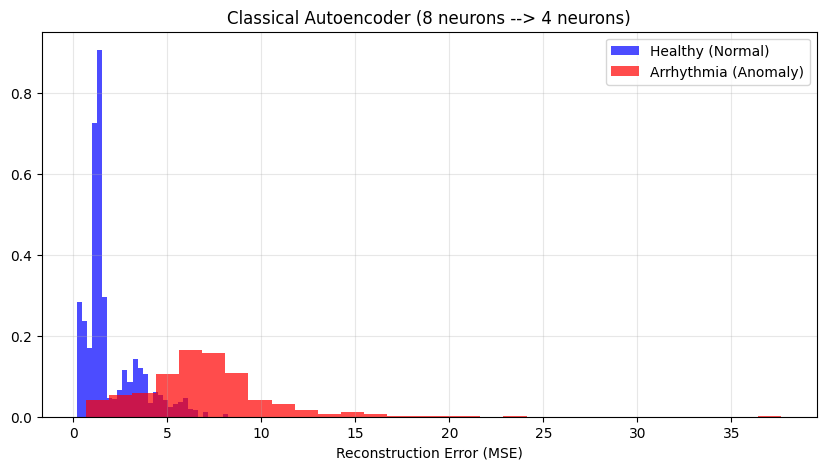


>>> Wyznaczony próg odcięcia (Threshold): 4.3968
>>> WYNIKI KOŃCOWE (KLASYCZNE):
    Dokładność (Accuracy): 86.88%


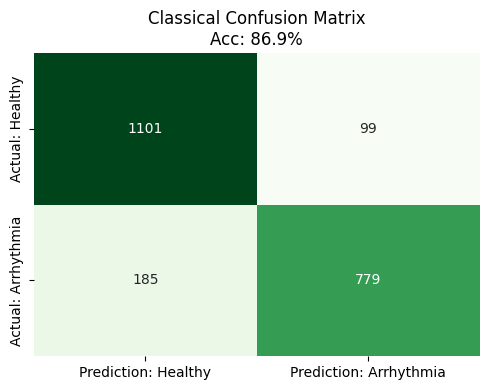

In [37]:
# --- CONFIGURATION (Same as in Quantum) ---
INPUT_DIM = 8       # Equivalent to 8 qubits
HIDDEN_DIM = 4      # Compression equivalent
LIMIT_SAMPLES = 600 # Change to 100, 300, 600 in subsequent tests

print(f">>> START: KLASYCZNY AUTOENKODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Loading Data
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("BŁĄD: Brak plików .npy! Uruchom prepare_data.py")
    exit()

print(f"    Trening na: {len(train_data)} próbkach")
print(f"    Dane treningowe: {train_data.shape}")

# 2. Classical Model (MLP)
# Architecture: Input(8) -> Hidden(4) -> Output(8)
# 'tanh' activation is closest to quantum gates (-1 to 1 range)
# 'adam' solver matches the optimizer used in deep networks
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Training (X -> X)
# In an autoencoder, input (X) is also the target (Y). The network must reconstruct the input.
print(">>> Trenowanie sieci neuronowej...")
autoencoder.fit(train_data, train_data)
print("    Trening zakończony.")
print(f"    Końcowy Loss: {autoencoder.loss_curve_[-1]:.6f}")

# TRAINING PROCESS VISUALIZATION (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Learning Curve (Classical Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f"result_images/classical_loss_{HIDDEN_DIM}latent.png")

# 4. Evaluation (Compute reconstruction error: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Error is the mean of squared differences between input and output
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Histogram visualization (Compare with IBM plot!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Healthy (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arrhythmia (Anomaly)', density=True)
plt.title(f"Classical Autoencoder (8 neurons --> 4 neurons)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f"result_images/classical_histogram_{HIDDEN_DIM}latent.png")
plt.show()

# ==========================================
# 6. CALCULATING ACCURACY (Classification)
# ==========================================
# We need to find the threshold that best separates the peaks
# In classical models, arrhythmia USUALLY has a LARGER error (on the right)

# Automatic threshold search (mean between the means of both distributions)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Wyznaczony próg odcięcia (Threshold): {threshold:.4f}")

# Classification:
# 0 = Healthy (Error < Threshold)
# 1 = Arrhythmia (Error > Threshold)
# NOTE: Here logic is "normal" (large error = disease).
# In quantum you can have "inversion". Here it likely won't be present.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> WYNIKI KOŃCOWE (KLASYCZNE):")
print(f"    Dokładność (Accuracy): {acc:.2%}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig(f"result_images/classical_confusion_matrix_{HIDDEN_DIM}latent.png")
plt.show()

>>> AUC (Area Under Curve): 0.9335


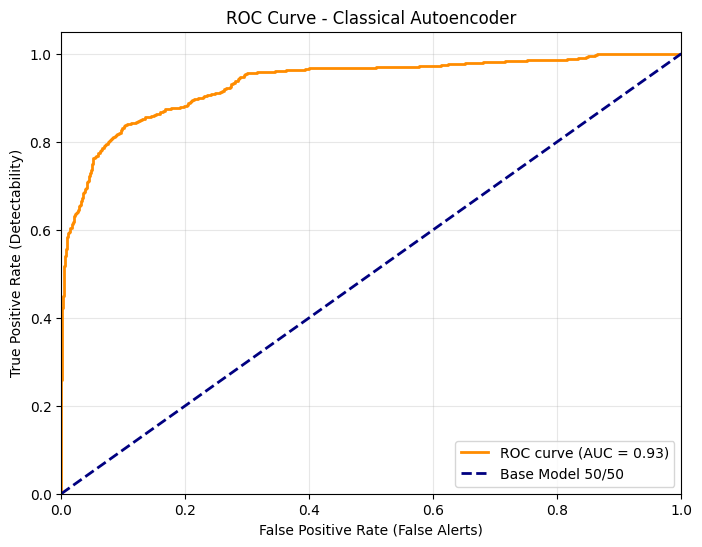

In [38]:
# --- 1. Data Preparation for ROC ---
# Need to combine the results into a single long vector
y_scores = np.concatenate([mse_normal, mse_anomaly])

# We need to create a vector of true labels (0 = Healthy, 1 = Arrhythmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Calculate ROC Curve ---
# The function returns:
# fpr = False Positive Rate (How many times we falsely triggered an alarm)
# tpr = True Positive Rate (How many times we correctly detected the disease)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Calculate AUC (Area Under Curve) ---
# This is the single number you put in the table (e.g., 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Area Under Curve): {roc_auc:.4f}")

# --- 4. Drawing the Plot ---
plt.figure(figsize=(8, 6))

# Draw the model curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Draw the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Base Model 50/50')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alerts)')
plt.ylabel('True Positive Rate (Detectability)')
plt.title('ROC Curve - Classical Autoencoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig(f"result_images/classical_roc_curve_{HIDDEN_DIM}latent.png")
plt.show()

>>> START: KLASYCZNY AUTOENKODER (Input: 8 -> Hidden: 2 -> Output: 8)
    Trening na: 600 próbkach
    Dane treningowe: (600, 8)
>>> Trenowanie sieci neuronowej...
    Trening zakończony.
    Końcowy Loss: 0.046667


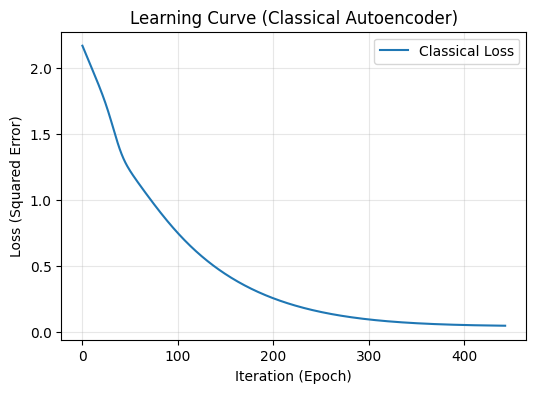

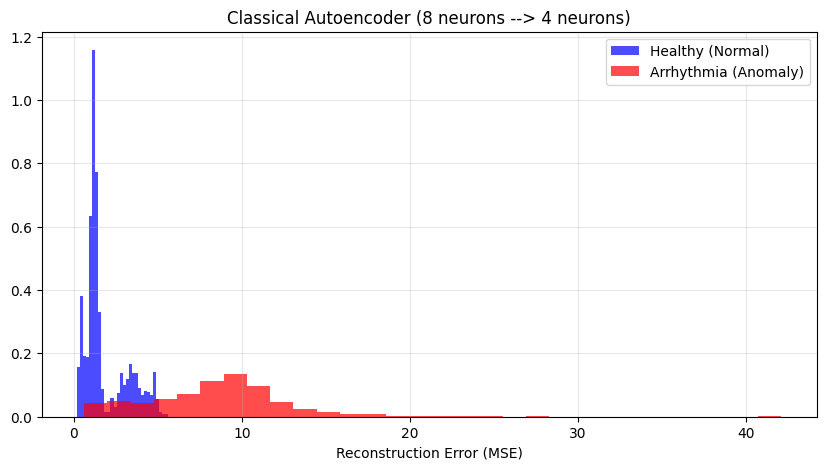


>>> Wyznaczony próg odcięcia (Threshold): 5.1338
>>> WYNIKI KOŃCOWE (KLASYCZNE):
    Dokładność (Accuracy): 90.34%


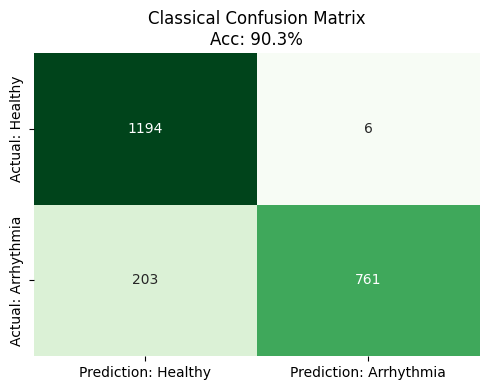

In [39]:
# --- CONFIGURATION (Same as in Quantum) ---
INPUT_DIM = 8       # Equivalent to 8 qubits
HIDDEN_DIM = 2      # Compression equivalent
LIMIT_SAMPLES = 600 # Change to 100, 300, 600 in subsequent tests

print(f">>> START: KLASYCZNY AUTOENKODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Loading Data
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("BŁĄD: Brak plików .npy! Uruchom prepare_data.py")
    exit()

print(f"    Trening na: {len(train_data)} próbkach")
print(f"    Dane treningowe: {train_data.shape}")

# 2. Classical Model (MLP)
# Architecture: Input(8) -> Hidden(4) -> Output(8)
# 'tanh' activation is closest to quantum gates (-1 to 1 range)
# 'adam' solver matches the optimizer used in deep networks
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Training (X -> X)
# In an autoencoder, input (X) is also the target (Y). The network must reconstruct the input.
print(">>> Trenowanie sieci neuronowej...")
autoencoder.fit(train_data, train_data)
print("    Trening zakończony.")
print(f"    Końcowy Loss: {autoencoder.loss_curve_[-1]:.6f}")

# TRAINING PROCESS VISUALIZATION (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Learning Curve (Classical Autoencoder)")
plt.xlabel("Iteration (Epoch)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f"result_images/classical_loss_{HIDDEN_DIM}_latent.png")

# 4. Evaluation (Compute reconstruction error: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Error is the mean of squared differences between input and output
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Histogram visualization (Compare with IBM plot!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Healthy (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arrhythmia (Anomaly)', density=True)
plt.title(f"Classical Autoencoder (8 neurons --> 4 neurons)")
plt.xlabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f"result_images/classical_histogram_{HIDDEN_DIM}latent.png")
plt.show()

# ==========================================
# 6. CALCULATING ACCURACY (Classification)
# ==========================================
# We need to find the threshold that best separates the peaks
# In classical models, arrhythmia USUALLY has a LARGER error (on the right)

# Automatic threshold search (mean between the means of both distributions)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Wyznaczony próg odcięcia (Threshold): {threshold:.4f}")

# Classification:
# 0 = Healthy (Error < Threshold)
# 1 = Arrhythmia (Error > Threshold)
# NOTE: Here logic is "normal" (large error = disease).
# In quantum you can have "inversion". Here it likely won't be present.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> WYNIKI KOŃCOWE (KLASYCZNE):")
print(f"    Dokładność (Accuracy): {acc:.2%}")

# Macierz Pomyłek
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Prediction: Healthy', 'Prediction: Arrhythmia'],
            yticklabels=['Actual: Healthy', 'Actual: Arrhythmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig(f"result_images/classical_confusion_matrix_{HIDDEN_DIM}latent.png")
plt.show()

>>> AUC (Pole pod krzywą): 0.9480


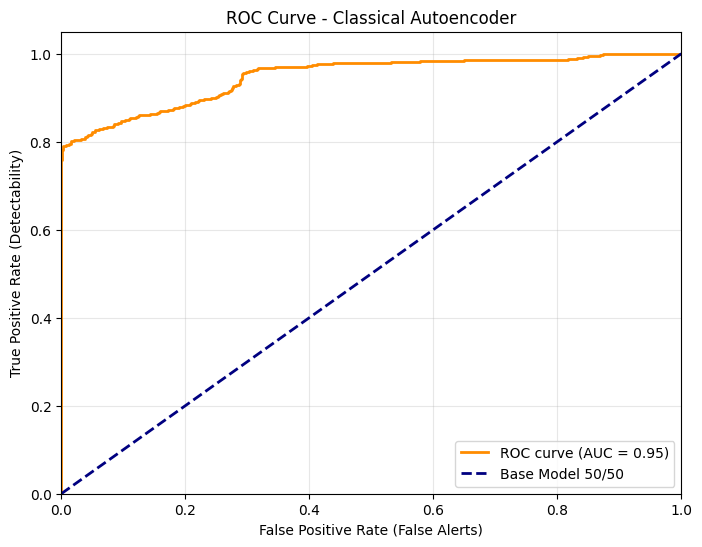

In [40]:
# --- 1. Data Preparation for ROC ---
# Need to combine the results into a single long vector
y_scores = np.concatenate([mse_normal, mse_anomaly])

# We need to create a vector of true labels (0 = Healthy, 1 = Arrhythmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Calculate ROC Curve ---
# The function returns:
# fpr = False Positive Rate (How many times we falsely triggered an alarm)
# tpr = True Positive Rate (How many times we correctly detected the disease)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Calculate AUC (Area Under Curve) ---
# This is the single number you put in the table (e.g., 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Pole pod krzywą): {roc_auc:.4f}")

# --- 4. Drawing the Plot ---
plt.figure(figsize=(8, 6))

# Draw the model curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Draw the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Base Model 50/50')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alerts)')
plt.ylabel('True Positive Rate (Detectability)')
plt.title('ROC Curve - Classical Autoencoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig(f"result_images/classical_roc_curve_{HIDDEN_DIM}latent.png")
plt.show()